# Import and variables

In [1]:
import numpy as np
import pandas as pd
from matplotlib.ticker import FormatStrFormatter
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

from src.results import get_scores_skills_table

In [3]:
ens_method = "rand_init"
ens_method_ls = [
    "rand_init",
    "bagging",
    "batchensemble",
    "bayesian",
    "mc_dropout",
    "concrete_dropout",
    "variational_dropout",
]
ens_method_labels = {
    "rand_init": "Naive",
    "bagging": "Bagging",
    "batchensemble": "BatchEns.",
    "bayesian": "Bayesian",
    "mc_dropout": "MC Dropout",
    "variational_dropout": "Var. Drop.",
    "concrete_dropout": "Conc. Drop.",
}
dataset_ls = [
    "boston",
    "concrete",
    "energy",
    "kin8nm",
    "naval",
    "power",
    "protein",
    "wine",
    "yacht",
]
dataset_labels = {
    "boston": "Boston \n Housing",
    "concrete": "Concrete \n Strength",
    "energy": "Energy \n Efficiency",
    "kin8nm": "Kin8nm",
    "naval": "Naval \n Propulsion",
    "power": "Power \n Plant",
    "protein": "Protein \n Structure",
    "wine": "Red \n Wine \n Quality",
    "yacht": "Yacht \n Hydrodynamics"
}
agg_labels = {
    "lp": r"$LP$",
    "vi": r"$V_0^=$",
    "vi-a": r"$V_a^=$",
    "vi-w": r"$V_0^w$",
    "vi-aw": r"$V_a^w$",
}

In [4]:
# Get colors
agg_cols = sns.color_palette("Dark2", 8, as_cmap=True)
# Colors of aggregation methods
agg_col = {
    "lp": agg_cols.colors[4],  # type: ignore
    "vi": agg_cols.colors[5],  # type: ignore
    "vi-a": agg_cols.colors[2],  # type: ignore
    "vi-w": agg_cols.colors[0],  # type: ignore
    "vi-aw": agg_cols.colors[3],  # type: ignore
    "ens": agg_cols.colors[7],  # type: ignore
    "opt": agg_cols.colors[1],  # type: ignore
}

greens = sns.color_palette("Greens", 2, as_cmap=False)
blues = sns.color_palette("Blues", 1)
purples = sns.color_palette("Purples", 1)
reds = sns.color_palette("Reds", 3)
ens_col = {
    "rand_init": greens[1], #multi_model_cols.colors[0],  # type: ignore
    "bagging": greens[0], #multi_model_cols.colors[1],  # type: ignore
    "batchensemble": blues[0], #multi_model_cols.colors[3],  # type: ignore
    "bayesian": purples[0], #multi_model_cols.colors[8],  # type: ignore
    "mc_dropout": reds[2], #dropout_cols.colors[14],  # type: ignore
    "variational_dropout": reds[1], #dropout_cols.colors[16],  # type: ignore
    "concrete_dropout": reds[0], #dropout_cols.colors[15],  # type: ignore
}

# KIT colors
kit_cols_dict = {
    "green": "#00876C",  # 26%
    "lightgreen": "#00e6b8",  # 45%
    "blue": "#4664AA",  # 47%
    "lightblue": "#a4b5da",  # 75%
    "black": "#000000",
    "grey": "#404040",
}

In [5]:
score_vec = ["crps", "crpss", "me", "lgt", "cov", "a", "w"]
nn_vec = ["drn", "bqn"]
n_ens_vec = np.arange(start=2, stop=20 + 2, step=2)
agg_meths = ["lp", "vi", "vi-a", "vi-w", "vi-aw"]

In [6]:
export = True
save_dir = os.path.join("plots", "results")

# Get and prepare data

In [7]:
df = pd.read_csv("98_single_model_evaluation.csv", sep=";")
df["Diff Mean 100"] = (df["Default MC"] - df["Mean 100"]) / df["Default MC"] * 100
df["Diff Mean 1000"] = (df["Default MC"] - df["Mean 1000"]) / df["Default MC"] * 100
df["Diff N ENS 100"] = (df["Default MC"] - df["N ENS 100"]) / df["Default MC"] * 100
df["Diff N ENS 1000"] = (df["Default MC"] - df["N ENS 1000"]) / df["Default MC"] * 100
df

,Unnamed: 0,Rand Init,Default MC,Mean 1000,Diff Mean 1000,Mean 100,Diff Mean 100,N ENS 100,Diff N ENS 100,N ENS 1000,Diff N ENS 1000
0,boston,1.874762,2.163253,2.049654,5.251304,2.039203,5.734419,2.058698,4.833230,2.041028,5.650056
1,concrete,5.919822,6.255906,6.142405,1.814302,6.221456,0.550680,6.154121,1.627023,6.224521,0.501686
2,energy,1.555607,1.904298,1.801979,5.373056,1.824164,4.208060,1.827598,4.027731,NaN,NaN
3,kin8nm,0.047229,0.069153,0.055888,19.182103,0.053078,23.245557,0.054984,20.489350,NaN,NaN
4,naval,0.001432,0.007666,0.007858,-2.504566,0.007545,1.578398,0.007757,-1.187060,NaN,NaN
5,power,2.407278,6.251255,4.136495,33.829367,5.067972,18.928727,5.140472,17.768960,NaN,NaN
6,protein,2.395475,2.446967,2.439730,0.295754,2.422402,1.003896,2.417892,1.188206,NaN,NaN
7,wine,0.354130,0.390260,0.375880,3.684723,0.371823,4.724286,0.379416,2.778660,NaN,NaN
8,yacht,3.724548,4.096527,2.721831,33.557596,3.910525,4.540480,3.952559,3.514392,NaN,NaN


In [12]:
df_melted = pd.melt(df, id_vars=["Unnamed: 0"], var_name="Variant", value_vars=["Diff Mean 1000", "Diff Mean 100", "Diff N ENS 100", "Diff N ENS 1000"], value_name="CRPS reduction [%]")

In [9]:
df_melted.head()

,Unnamed: 0,Variant,CRPS reduction
0,boston,Diff Mean 1000,5.251304
1,concrete,Diff Mean 1000,1.814302
2,energy,Diff Mean 1000,5.373056
3,kin8nm,Diff Mean 1000,19.182103
4,naval,Diff Mean 1000,-2.504566


# Final plots

## CRPS reduction compared to default MC dropout

In [10]:
agg_colors = {
    "Diff Mean 100": kit_cols_dict["green"],
    "Diff Mean 1000": kit_cols_dict["lightgreen"],
    "Diff N ENS 100": kit_cols_dict["blue"],
    "Diff N ENS 1000": kit_cols_dict["lightblue"],
}

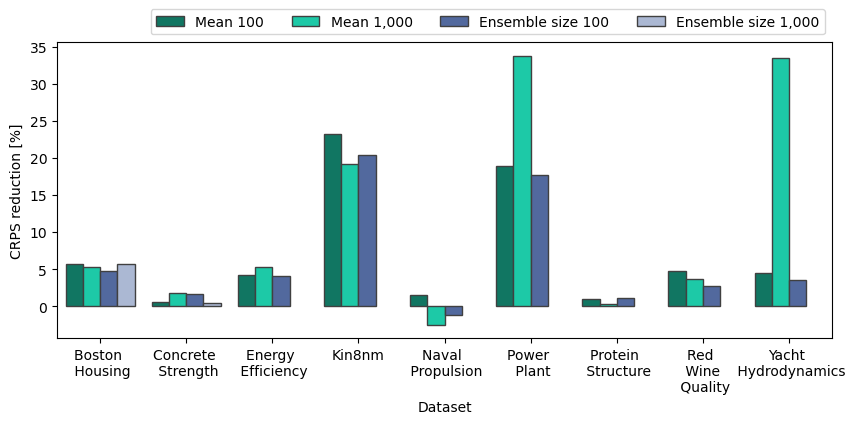

In [13]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)


hue_order = ["Diff Mean 100", "Diff Mean 1000", "Diff N ENS 100", "Diff N ENS 1000"]
sns.barplot(df_melted, x="Unnamed: 0", y="CRPS reduction [%]", hue="Variant", edgecolor=kit_cols_dict["grey"], hue_order=hue_order, palette=agg_colors)

curr_handles, curr_labels = ax.get_legend_handles_labels()
ax.legend([],[], frameon=False)
labels = ["Mean 100", "Mean 1,000", "Ensemble size 100", "Ensemble size 1,000"]
ax.set_xticklabels([dataset_labels.get(column_name) for column_name in dataset_ls])
ax.set_xlabel("Dataset")
fig.subplots_adjust(top=0.85)
fig.legend(curr_handles, labels, bbox_to_anchor=(0.9, 0.95), ncol=4)
# fig.suptitle("CRPS reduction compared to MC dropout with one prediction per test sample (in %)", y=1)

filename=os.path.join(save_dir, "98_single_model_evaluation.pdf")
fig.savefig(filename, bbox_inches='tight')
filename=os.path.join(save_dir, "98_single_model_evaluation.png")
fig.savefig(filename, bbox_inches='tight')

## Bar plot skill change max vs min ensemble

In [7]:
dataset_labels = {
    "scen_1": "Scenario 1 \n (N=16,000)",
    "scen_4": "Scenario 2 \n (N=16,000)",
    "boston": "Boston Housing \n (N=506)",
    "concrete": "Concrete Strength \n (N=1,030)",
    "energy": "Energy Efficiency \n (N=768)",
    "kin8nm": "Kin8nm \n (N=8,192)",
    "naval": "Naval Propulsion \n (N=11,934)",
    "power": "Power Plant \n (N=9,568)",
    "protein": "Protein Structure \n (N=45,730)",
    "wine": "Red Wine Quality \n (N=1,599)",
    "yacht": "Yacht\n Hydrodynamics \n (N=308)"
}

In [8]:
data_path = os.path.join("..", "..", "04_Experiments", "single_models_final")
df_scores, df_skills = get_scores_skills_table(data_path, dataset_ls, score_vec, nn_vec, n_ens_vec, agg_meths, ens_method_ls)  # type: ignore

# Add change to skills table
df_skills["change"] = df_skills["skill_20"] - df_skills["skill_2"]

KeyboardInterrupt: 

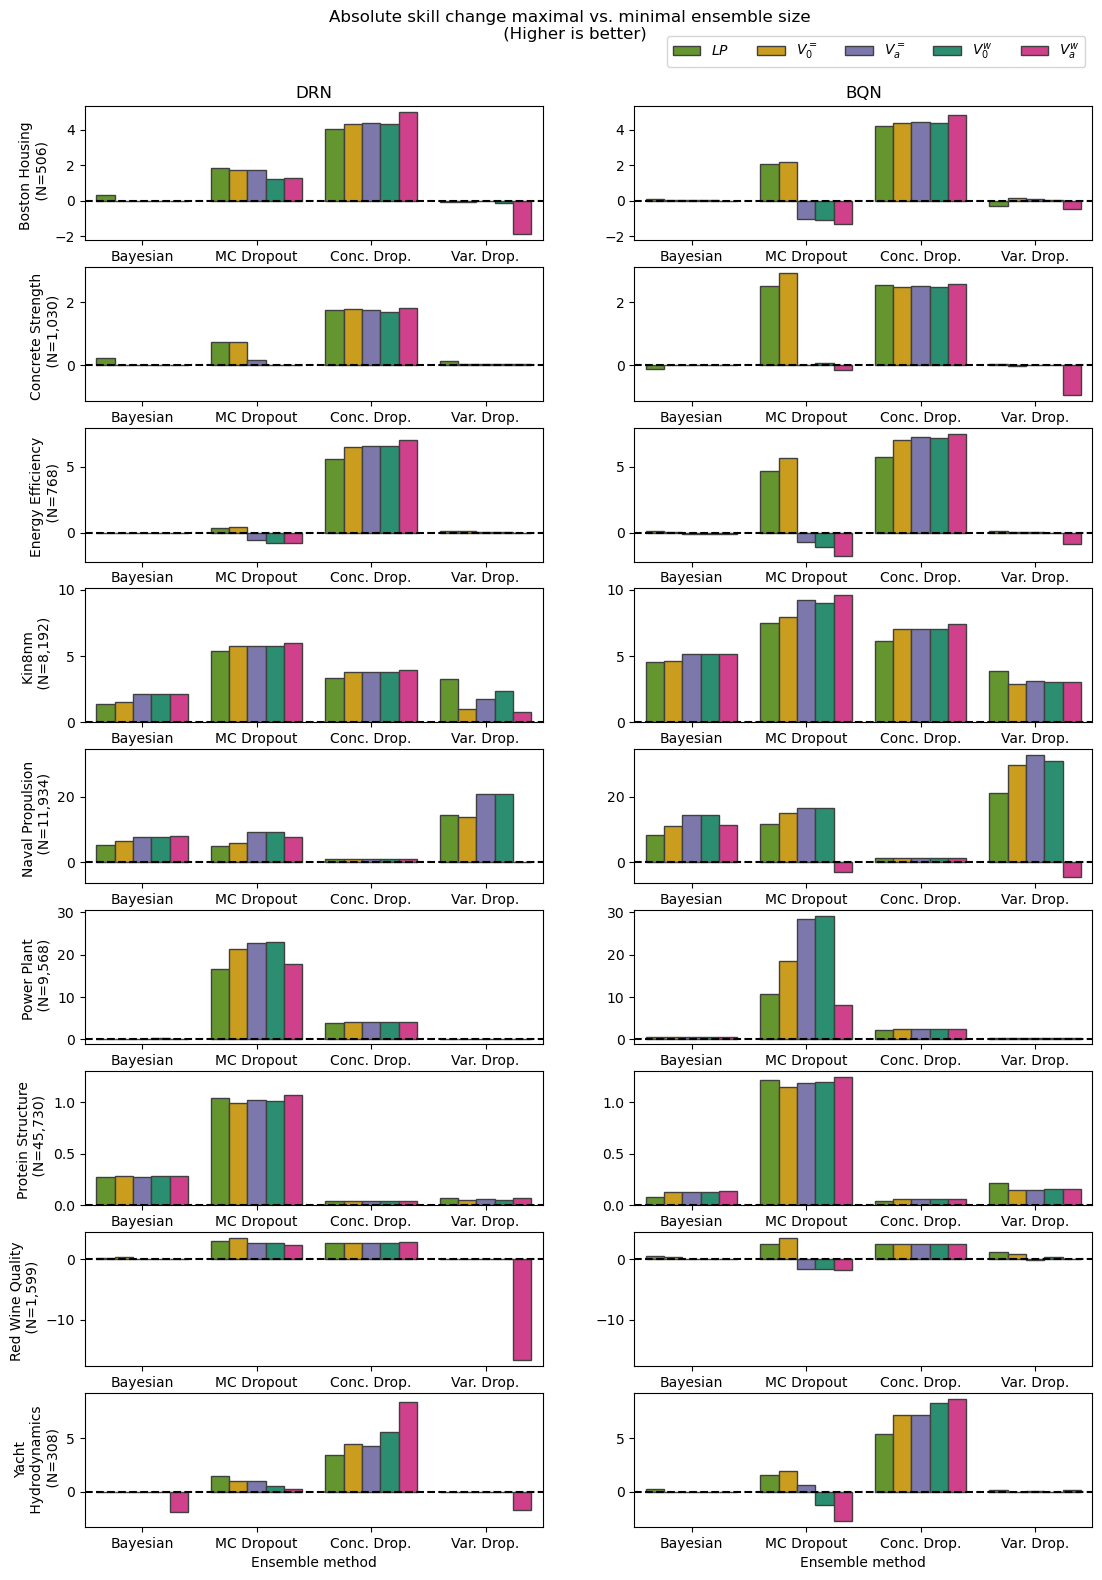

In [28]:
##### Skill - Barplot - x=ensemble_method #####

# Create subplots
fig, axs = plt.subplots(nrows=len(dataset_ls), ncols=len(nn_vec), figsize=(13,16*1.2), squeeze=False)

# Iterate over NN types and datasets
for i_nn, nn in enumerate(nn_vec):
    df_nn = df_skills[df_skills["nn"] == nn]
    for i_dataset, dataset in enumerate(dataset_ls):
        df_nn_dataset = df_nn[(df_nn["dataset"] == dataset)]
        
        # Plot boxplots
        g = sns.barplot(ax=axs[i_dataset][i_nn], data=df_nn_dataset,
                 y="change", x="ens_method", hue="agg", palette=agg_col, edgecolor=kit_cols_dict["grey"], order=ens_method_ls)
        
        # Add 0 line
        g.axhline(0, linestyle="--", color=kit_cols_dict["black"])
        # Add labels to x and y axis
        axs[i_dataset][i_nn].set_ylabel("")
        axs[i_dataset][0].set_ylabel(dataset_labels[dataset])
        axs[i_dataset][i_nn].set_xticklabels([ens_method_labels.get(column_name) for column_name in ens_method_ls])
        axs[i_dataset][i_nn].set_xlabel("")
        axs[len(dataset_ls)-1][i_nn].set_xlabel("Ensemble method")

# Remove subplot legends and add figure legend
for ax in [item for sublist in axs for item in sublist]:
    ax.legend([],[], frameon=False)

# Merge subplot legends and displaz figure legend
handles = []
labels = []
for ax in [item for sublist in axs for item in sublist]:
    curr_handles, curr_labels = ax.get_legend_handles_labels()
    for idx, check_label in enumerate(curr_labels):
        if check_label not in labels:
            handles.append(curr_handles[idx])
            labels.append(curr_labels[idx])
    ax.legend([],[], frameon=False)
labels = [agg_labels.get(agg) for agg in labels]
fig.legend(handles, labels, bbox_to_anchor=(0.9, 0.89), ncol=len(agg_meths))

# Set y axis range
# limits = {
#     "boston": [-100, 400],
#     "concrete": [-200,500],
#     "energy": [-50, 400],
#     "kin8nm": [0, 200],
#     "naval": [0, 200],
#     "power": [-100, 200],
#     "protein": [0, 250],
#     "wine": [-50, 300],
#     "yacht": [-100 , 500],
# }
for idx, (ax_drn, ax_bqn) in enumerate(axs):
    drn_l, drn_u = ax_drn.get_ylim()
    bqn_l, bqn_u = ax_bqn.get_ylim()
    drn_range = drn_u - drn_l
    bqn_range = bqn_u - bqn_l
    
    ax_drn.set_ylim(min(drn_l, bqn_l), max(drn_u, bqn_u))
    ax_bqn.set_ylim(min(drn_l, bqn_l), max(drn_u, bqn_u))
    
    # hard_cut_l, hard_cut_u = list(limits.values())[idx]
    # ax_drn.set_ylim(max(hard_cut_l, min(drn_l, bqn_l)), min(hard_cut_u, max(drn_u, bqn_u)))
    # ax_bqn.set_ylim(max(hard_cut_l, min(drn_l, bqn_l)), min(hard_cut_u, max(drn_u, bqn_u)))

# Set titles and legends
axs[0][0].set_title("DRN")
axs[0][1].set_title("BQN")
fig.subplots_adjust(top=0.85)
fig.suptitle(f"Absolute skill change maximal vs. minimal ensemble size \n (Higher is better)", y=0.9)


# Save figure
if export:
    filename=os.path.join(save_dir, "98_single_model_skill_barplot_change.pdf")
    fig.savefig(filename, bbox_inches='tight')
    filename=os.path.join(save_dir, "98_single_model_skill_barplot_change.png")
    fig.savefig(filename, bbox_inches='tight')

## Lineplot - Skill per aggregation and ensemble method

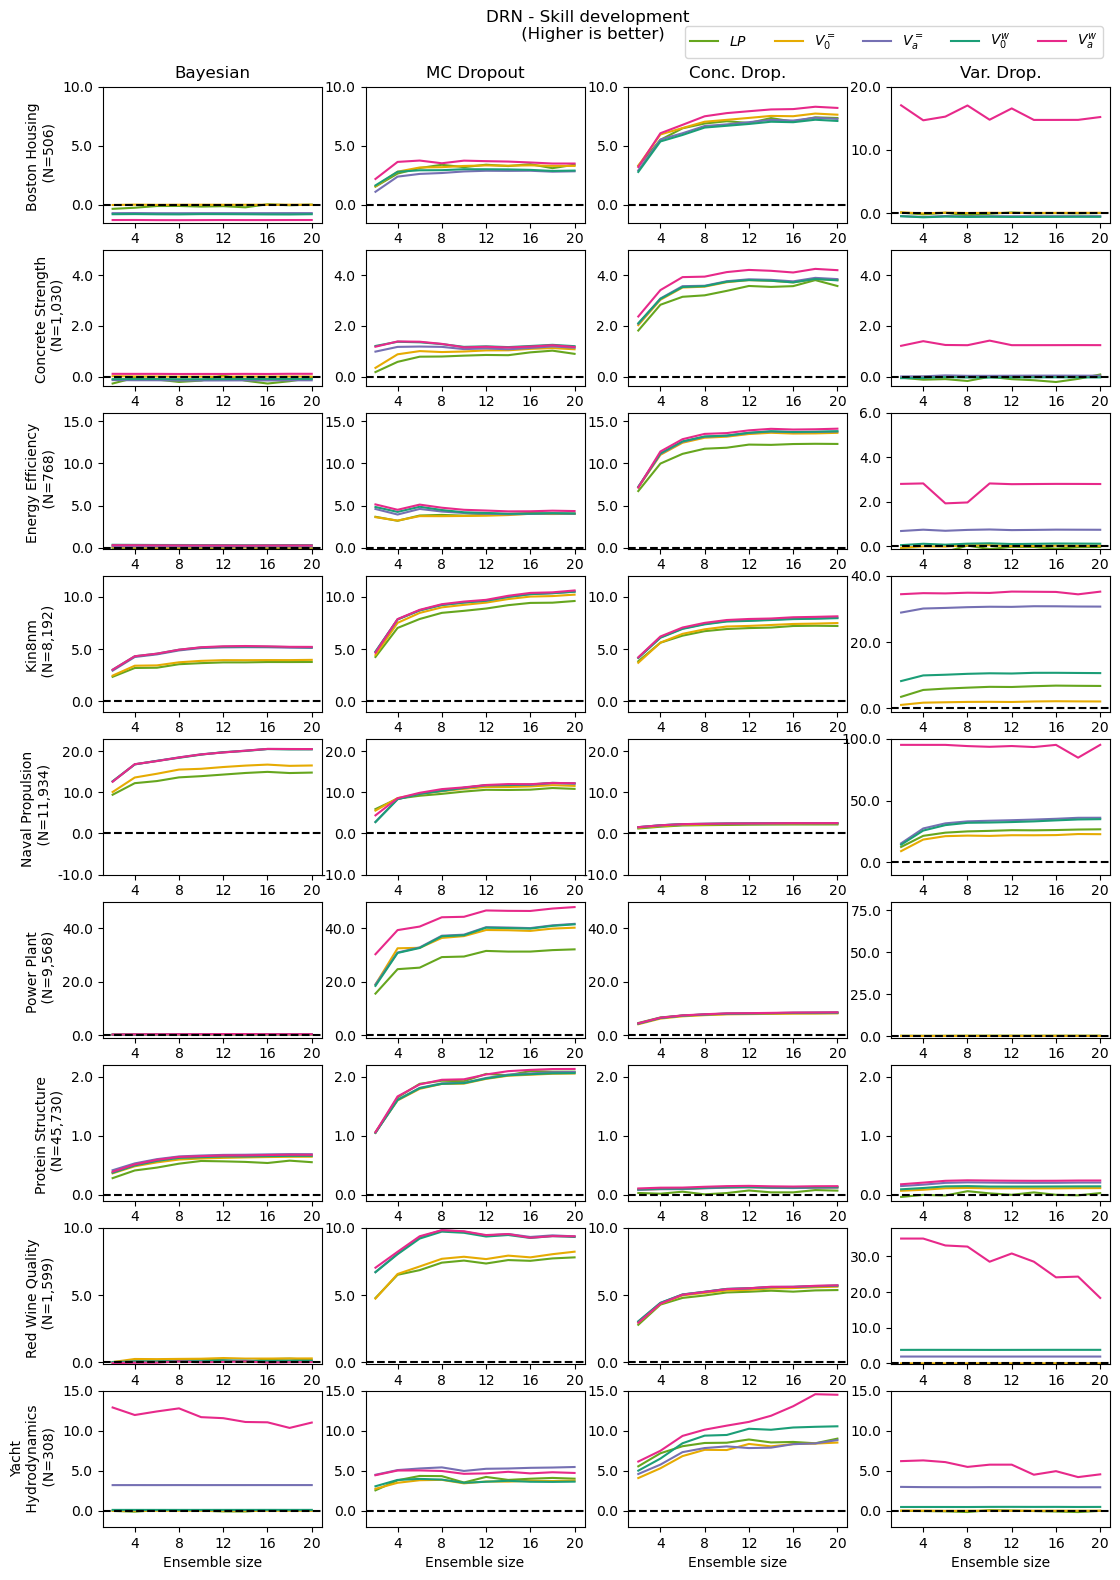

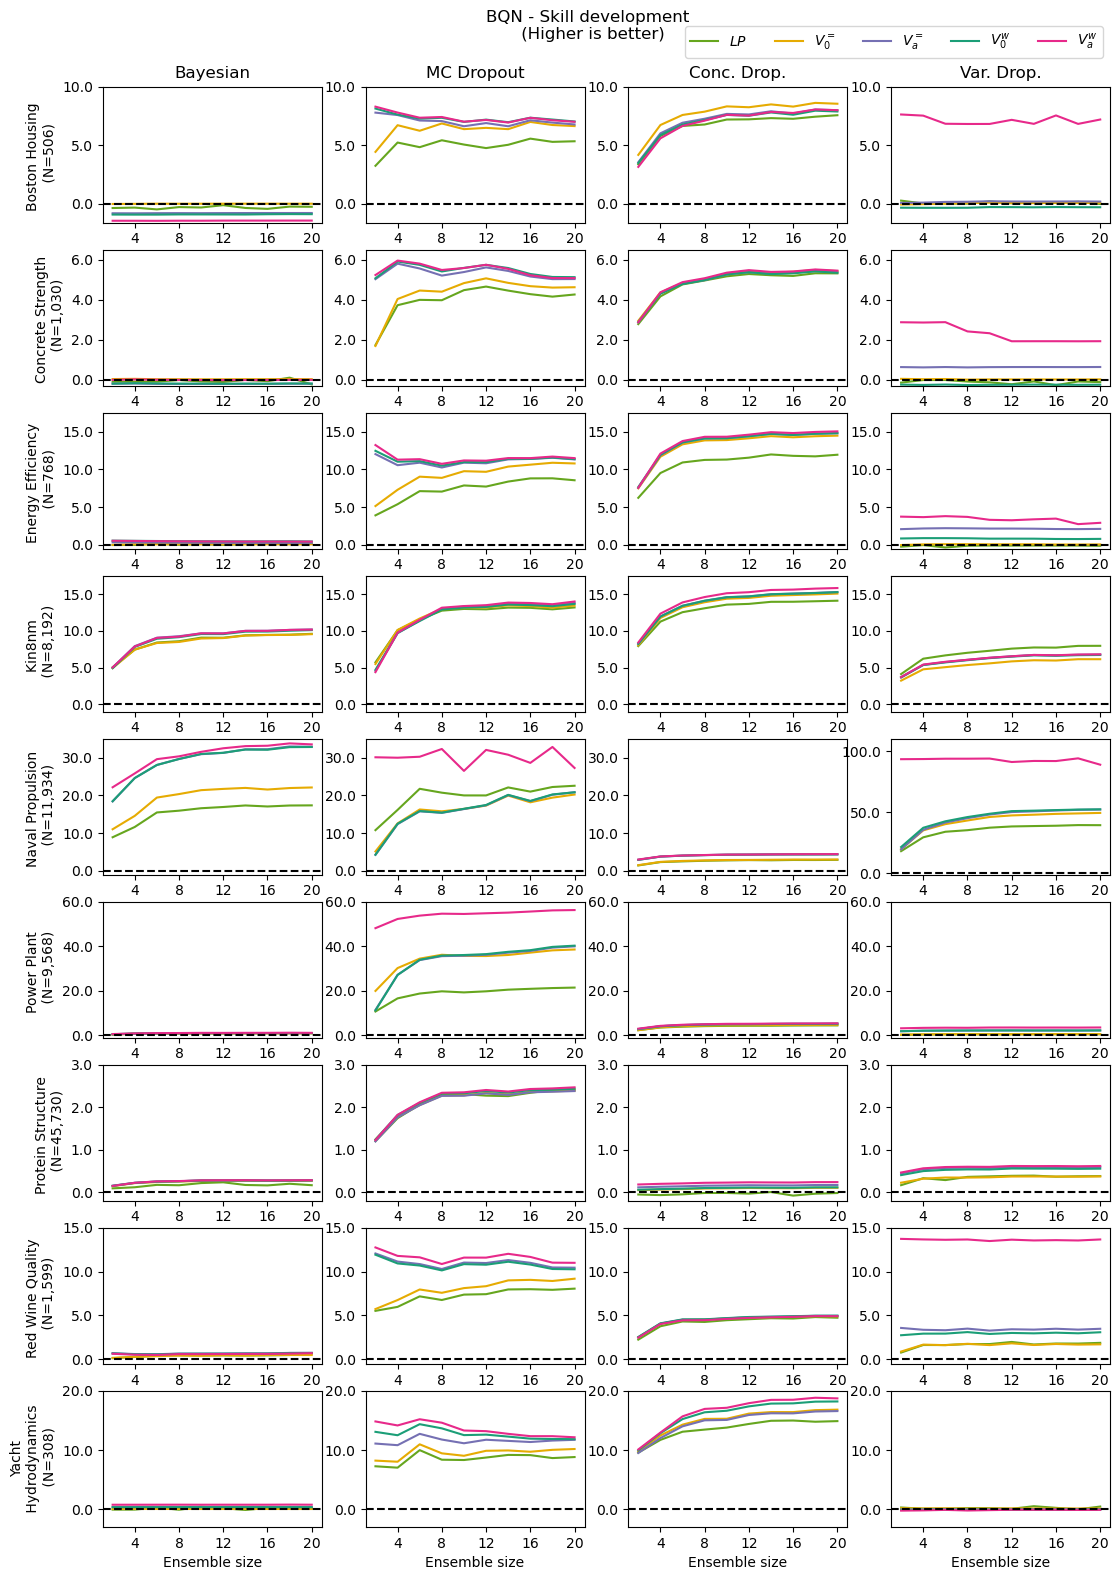

In [42]:
##### Skill - Lineplot - x=ensemble_size - Columns=ensemble_method #####

# Iterate over NN types and datasets
for i_nn, nn in enumerate(nn_vec):
    # Create subplots
    fig, axs = plt.subplots(nrows=len(dataset_ls), ncols=len(ens_method_ls), figsize=(13,16*1.2), squeeze=False)
    df_nn = df_skills[df_skills["nn"] == nn]
    for i_ens, ens_method in enumerate(ens_method_ls):
        df_nn_ens = df_nn[(df_nn["ens_method"] == ens_method)]
        for i_dataset, dataset in enumerate(dataset_ls):
            df_nn_dataset = df_nn_ens[(df_nn_ens["dataset"] == dataset)]
            
            # Melt dataframe for sns plots
            df_melt = pd.melt(df_nn_dataset, id_vars=["ens_method", "dataset", "nn", "agg"], var_name="ensemble_size", value_name="skill")
            # Only use skills not differences
            df_final = df_melt[df_melt["ensemble_size"].isin([f"skill_{n_ens}" for n_ens in n_ens_vec])]
                
            # Plot boxplots
            g = sns.lineplot(ax=axs[i_dataset][i_ens], data=df_final,
                    y="skill", x="ensemble_size", hue="agg", palette=agg_col)
            
            # Add 0 line
            g.axhline(0, linestyle="--", color=kit_cols_dict["black"])
            # Add labels to x and y axis
            axs[i_dataset][i_ens].set_ylabel("")
            axs[i_dataset][0].set_ylabel(dataset_labels[dataset])
            axs[i_dataset][i_ens].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            with_ticks = True
            if with_ticks:
                start, end = ax.get_xlim()
                # axs[i_dataset][i_ens].xaxis.set_ticks(list(np.arange(start, end, 4)))
                axs[i_dataset][i_ens].set_xticks([1, 3, 5, 7, 9])
                axs[i_dataset][i_ens].set_xticklabels(["4", "8", "12", "16", "20"])
            else:
                if i_ens != 0:
                    axs[i_dataset][i_ens].tick_params(axis="both", which="both", left=False, labelleft=False)
                    # axs[i_dataset][i_ens].set_yticklabels("")
                if i_dataset != len(dataset_ls) - 1:
                    # axs[i_dataset][i_ens].set_xticklabels("")
                    axs[i_dataset][i_ens].tick_params(axis="both", which="both", bottom=False, labelbottom=False)
                else:
                    axs[i_dataset][i_ens].set_xticklabels([str(i_ens) for i_ens in n_ens_vec])
            axs[i_dataset][i_ens].set_xlabel("")
        axs[len(dataset_ls)-1][i_ens].set_xlabel("Ensemble size")

    # Remove subplot legends and add figure legend
    for ax in [item for sublist in axs for item in sublist]:
        ax.legend([],[], frameon=False)

    # Merge subplot legends and displaz figure legend
    handles = []
    labels = []
    for ax in [item for sublist in axs for item in sublist]:
        curr_handles, curr_labels = ax.get_legend_handles_labels()
        for idx, check_label in enumerate(curr_labels):
            if check_label not in labels:
                handles.append(curr_handles[idx])
                labels.append(curr_labels[idx])
        ax.legend([],[], frameon=False)
    labels = [agg_labels.get(agg) for agg in labels]
    fig.legend(handles, labels, bbox_to_anchor=(0.9, 0.895), ncol=len(agg_meths))

    # # Set y axis range
    limits = {
        "drn": {
            # "scen_1": [-15, 50],
            # "scen_4": [-1, 28],
            "boston": [-1.5, 10],
            "concrete": [-0.35, 5],
            "energy": [-0.1, 16],
            "kin8nm": [-1, 12],
            "naval": [-10, 23],
            "power": [-1, 50],
            "protein": [-0.1, 2.2],
            "wine": [-0.1, 10],
            "yacht": [-2, 15],
        },
        "bqn": {
            # "scen_1": [-4, 35],
            # "scen_4": [-4, 35],
            "boston": [-1.6, 10],
            "concrete": [-0.3, 6.5],
            "energy": [-0.5, 17.5],
            "kin8nm": [-1, 17.5],
            "naval": [-1, 35],
            "power": [-1, 60],
            "protein": [-0.2, 3],
            "wine": [-0.5, 15],
            "yacht": [-3, 20],
        }
    }
    limits_var_dropout = {
        "drn": {
            # "scen_1": [-15, 50],
            # "scen_4": [-1, 28],
            "boston": [-1.5, 20],
            "concrete": [-0.35, 5],
            "energy": [-0.1, 6],
            "kin8nm": [-1, 40],
            "naval": [-10, 100],
            "power": [-1, 80],
            "protein": [-0.1, 2.2],
            "wine": [-0.1, 38],
            "yacht": [-2, 15],
        },
        "bqn": {
            # "scen_1": [-4, 35],
            # "scen_4": [-4, 35],
            "boston": [-1.6, 10],
            "concrete": [-0.3, 6.5],
            "energy": [-0.5, 17.5],
            "kin8nm": [-1, 17.5],
            "naval": [-1, 110],
            "power": [-1, 60],
            "protein": [-0.2, 3],
            "wine": [-0.5, 15],
            "yacht": [-3, 20],
        }
    }
    for idx, ax_i_ens in enumerate(axs):       
        for jdx, ax in enumerate(ax_i_ens):
            hard_cut_l, hard_cut_u = list(limits[nn].values())[idx]
            # if (nn == "bqn") & (jdx == 4) & (idx == 7):  # BQN, MC Dropout, Power
            #     hard_cut_l = -1.5
            #     hard_cut_u = 40
            if jdx == 3:
                hard_cut_l, hard_cut_u = list(limits_var_dropout[nn].values())[idx]
            ax.set_ylim(hard_cut_l, hard_cut_u)

    # Set titles and legends
    for i_ens, ens_method in enumerate(ens_method_ls):
        axs[0][i_ens].set_title(ens_method_labels[ens_method])
    fig.subplots_adjust(top=0.86)
    fig.suptitle(f"{nn.upper()} - Skill development \n (Higher is better)", y=0.9)


    # Save figure
    if export:
        filename=os.path.join(save_dir, f"98_single_models_skill_lineplot_{nn}.pdf")
        fig.savefig(filename, bbox_inches='tight')
        filename=os.path.join(save_dir, f"98_single_models_skill_lineplot_{nn}.png")
        fig.savefig(filename, bbox_inches='tight')

## Runtime evaluation

In [6]:
data_path = os.path.join("..", "..", "04_Experiments", "single_models_final")

df_final = pd.DataFrame()

for dataset in dataset_ls:
    for ens_method in ens_method_ls:
        dir_path = os.path.join(data_path, dataset, ens_method)
        filename = f"runtime_{dataset}_{ens_method}.pkl"
        with open(os.path.join(data_path, filename), "rb") as f:
            df_runtime = pickle.load(f)
        df_runtime["ens_method"] = ens_method
        
        df_final = pd.concat(
            [
                df_final,
                pd.DataFrame(df_runtime),
            ],
            ignore_index=True,
        )

df_final["runtime_train_s"] = df_final["runtime_train"] / 1e+9
df_final["runtime_pred_s"] = df_final["runtime_pred"] / 1e+9


In [7]:
df_final.groupby("ens_method")["runtime_pred_s"].mean()

ens_method
bayesian               0.091018
concrete_dropout       0.065760
mc_dropout             0.974710
variational_dropout    1.092381
Name: runtime_pred_s, dtype: float64

In [61]:
df_final[(df_final["dataset"].isin(["boston", "concrete", "energy", "kin8nm", "naval", "power", "protein", "yacht"])) & (df_final["ens_method"].isin(["bayesian", "concrete_dropout", "variational_dropout"]))]["runtime_pred_s"].mean()

0.20190019218237262

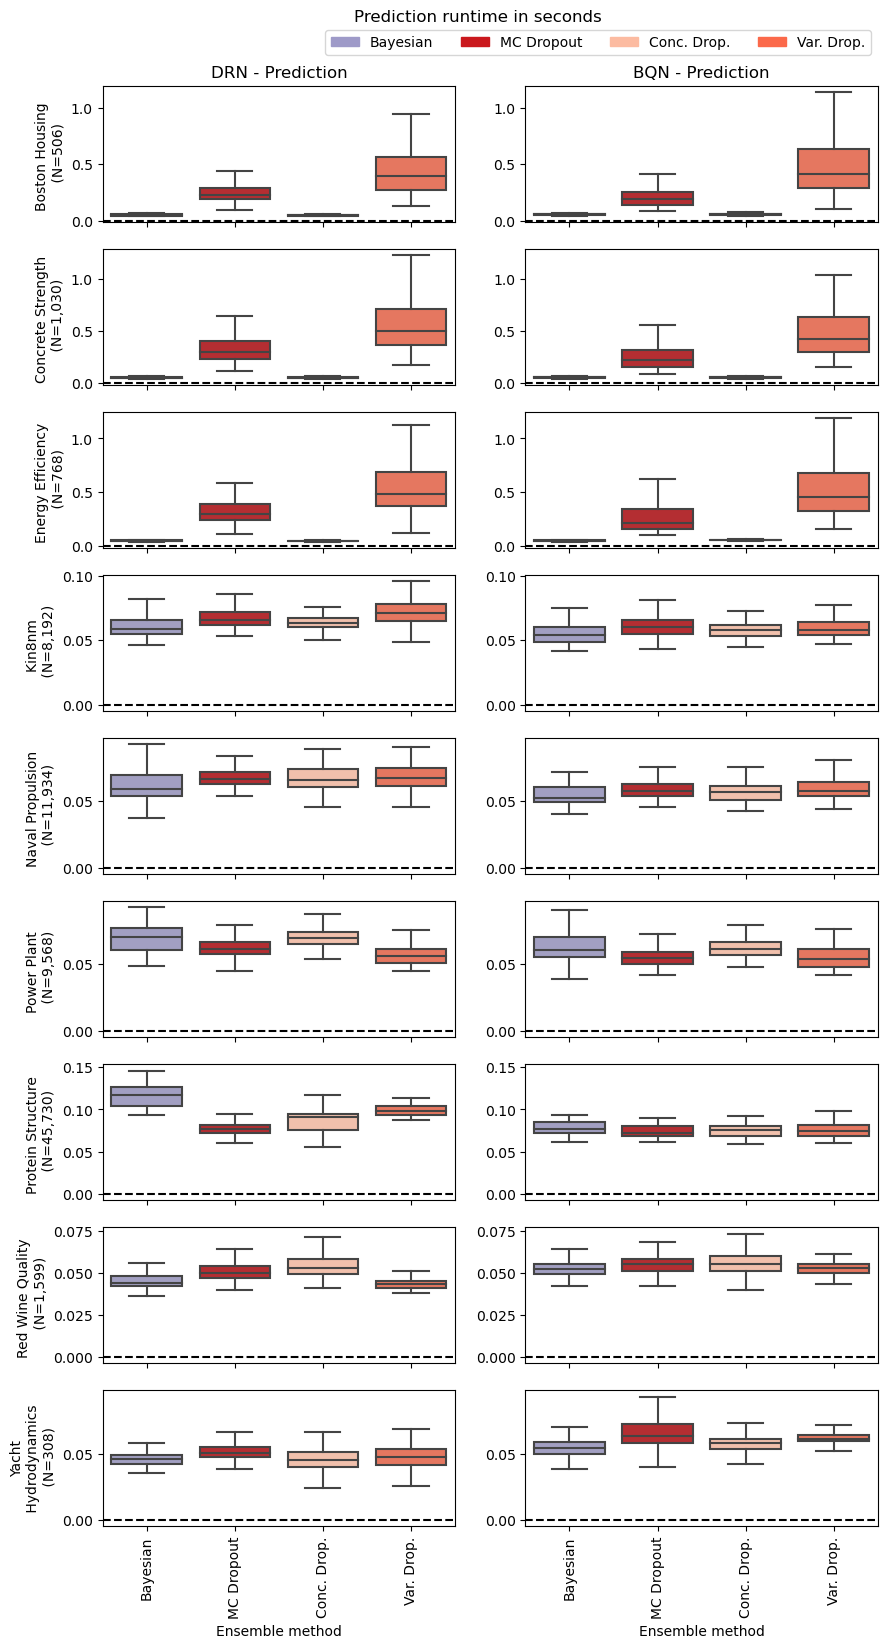

In [10]:
##### Skill - Boxplots - x=aggregation_methods #####

# Temp:
nn_vec = df_final["nn"].unique()

# Create subplots
fig, axs = plt.subplots(nrows=len(dataset_ls), ncols=len(nn_vec), figsize=(10,16*1.2), squeeze=False)

# Iterate over NN types and datasets
for i_nn, nn in enumerate(nn_vec):
    df_nn = df_final[df_final["nn"] == nn]
    for i_dataset, dataset in enumerate(dataset_ls):
        df_nn_dataset = df_nn[(df_nn["dataset"] == dataset)]
        
        #### Train runtime ####                
        # Plot boxplots
        # f = sns.boxplot(ax=axs[i_dataset][i_nn], data=df_nn_dataset, y="runtime_train_s", x="ens_method", showfliers=False, color=kit_cols_dict["green"], palette=ens_col, order=ens_method_ls)
        g = sns.boxplot(ax=axs[i_dataset][i_nn], data=df_nn_dataset, y="runtime_pred_s", x="ens_method", showfliers=False, color=kit_cols_dict["green"], palette=ens_col, order=ens_method_ls)
        
        # Add 0 line
        # f.axhline(0, linestyle="--", color=kit_cols_dict["black"])
        g.axhline(0, linestyle="--", color=kit_cols_dict["black"])
        # Add labels to x and y axis
        axs[i_dataset][i_nn].set_ylabel("")
        # axs[i_dataset][len(nn_vec)+i_nn].set_ylabel("")
        axs[i_dataset][0].set_ylabel(dataset_labels[dataset])
        if i_dataset == len(dataset_ls)-1:
            axs[i_dataset][i_nn].set_xticklabels([ens_method_labels.get(ens_method) for ens_method in ens_method_ls], rotation=90)
            # axs[i_dataset][len(nn_vec)+i_nn].set_xticklabels([ens_method_labels.get(ens_method) for ens_method in ens_method_ls], rotation=90)
            axs[i_dataset][i_nn].set_xlabel("Ensemble method")
            # axs[i_dataset][len(nn_vec)+i_nn].set_xlabel("Ensemble method")
        else:
            axs[i_dataset][i_nn].tick_params(axis="x", which="both", top=False, labelbottom=False)
            # axs[i_dataset][len(nn_vec)+i_nn].tick_params(axis="x", which="both", top=False, labelbottom=False)
            axs[i_dataset][i_nn].set_xlabel("")
            # axs[i_dataset][len(nn_vec)+i_nn].set_xlabel("")
        # Set titles
        axs[0][i_nn].set_title(f"{nn.upper()} - Prediction")
        # axs[0][len(nn_vec)+i_nn].set_title(f"{nn.upper()} - Prediction")


# # Remove subplot legends and add figure legend
for ax in [item for sublist in axs for item in sublist]:
    ax.legend([],[], frameon=False)
handles = []
handles = [matplotlib.patches.Patch(color=ens_col.get(ens_method)) for ens_method in ens_method_ls]  # type: ignore
labels = [ens_method_labels.get(ens_method) for ens_method in ens_method_ls]


# Set y axis range
for ax_drn_pred, ax_bqn_pred in axs:
    # train_l = min(ax_drn_train.get_ylim()[0], ax_bqn_train.get_ylim()[0])
    # train_u = max(ax_drn_train.get_ylim()[1], ax_bqn_train.get_ylim()[1])
    pred_l = min(ax_drn_pred.get_ylim()[0], ax_bqn_pred.get_ylim()[0])
    pred_u = max(ax_drn_pred.get_ylim()[1], ax_bqn_pred.get_ylim()[1])
        
    # ax_drn_train.set_ylim(train_l, train_u)
    # ax_bqn_train.set_ylim(train_l, train_u)
    ax_drn_pred.set_ylim(pred_l, pred_u)
    ax_bqn_pred.set_ylim(pred_l, pred_u)

# Set titles and legends
fig.subplots_adjust(top=0.86)
fig.legend(handles, labels, bbox_to_anchor=(0.9, 0.893), ncol=len(ens_method_ls))
fig.suptitle(f"Prediction runtime in seconds", y=0.9)

# Save figure
if export:
    filename=os.path.join(save_dir, "98_single_models_runtime_boxplot.pdf")
    fig.savefig(filename, bbox_inches='tight')
    filename=os.path.join(save_dir, "98_single_models_runtime_boxplot.png")
    fig.savefig(filename, bbox_inches='tight')